In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

## The basic model: amplification and persistance

In [5]:
# define some variables
t, k, K, B, u, q = sym.symbols('t, k, K, B, u, q')

# define some parameters
a, alpha, K_bar, m, R = sym.symbols('a, alpha, K_bar, m, R')

# need to specify some production function for gatherers
G = k**alpha
mpk = sym.diff(G, k, 1)

# basic model from Kiyotaki and Moore "credit-cycles" paper
K_dot = (1 / u) * ((a + q) * K - R * B) - K
B_dot = (1 / R) * q * K - B
q_dot = (R - 1) * q - R * u
u_dot = (1 / R) * mpk.subs({k: (1 / m) * (K_bar - K)}) - u

rhs = {'K': K_dot, 'B': B_dot, 'q': q_dot, 'u': u_dot}

In [91]:
bcs = {}

def Kstar(a, m, alpha, R, K_bar):
    return K_bar - m * (alpha / (a * R))**(1 / (1 - alpha))

def Bstar(a, m, alpha, R, K_bar):
    return (a / (R - 1)) * Kstar(a, m, alpha, R, K_bar)

params = {'a': 1.01, 'm': 1.0, 'alpha': 0.33, 'R': 1.05, 'K_bar': 100}

# initial conditions for K and B are given
K0, B0 = 10.0, Bstar(**params)
bcs['lower'] = [K - K0, B - B0]

# boundary conditions on q and u can be written in terms of steady state values
bcs['upper'] = [q - ((R / (R - 1)) * a), u - a]

In [92]:
# set up the model and solver
basic_model = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['K', 'B', 'q', 'u'],
                                                         independent_var='t',
                                                         rhs=rhs,
                                                         boundary_conditions=bcs,
                                                         params=params)

basic_model_solver = pycollocation.OrthogonalPolynomialSolver(basic_model)

In [93]:
# specify an initial guess
domain = [0, 50]
ts = np.linspace(domain[0], domain[1], 1000)
Ks = Kstar(**params) - (Kstar(**params) - K0) * np.exp(-ts) #* np.cos(2.0 * np.pi * ts)
initial_capital_poly = np.polynomial.Chebyshev.fit(ts, Ks, 35, domain)

Bs = Bstar(**params) - (Bstar(**params) - B0) * np.exp(-ts) #* np.cos(2.0 * np.pi * ts)
initial_debt_poly = np.polynomial.Chebyshev.fit(ts, Bs, 25, domain)

us = (params['alpha'] / params['R']) * ((1 / params['m']) * (params['K_bar'] - Ks))**(params['alpha'] - 1)
initial_user_cost_poly = np.polynomial.Chebyshev.fit(ts, us, 25, domain)

qs = Ks
initial_land_price_poly = np.polynomial.Chebyshev.fit(ts, qs, 25, domain)

initial_coefs = {'K': initial_capital_poly.coef, 'B': initial_debt_poly.coef, 
                 'u': initial_user_cost_poly.coef, 'q': initial_land_price_poly.coef}

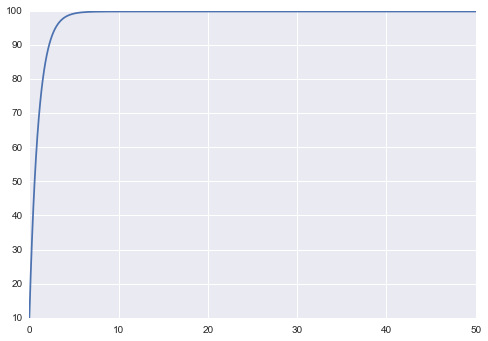

In [94]:
plt.plot(ts, initial_capital_poly(ts))
plt.show()

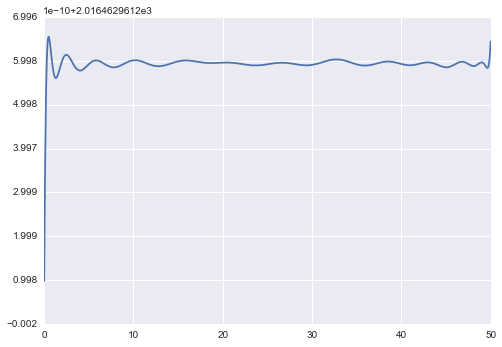

In [95]:
plt.plot(ts, initial_debt_poly(ts))
plt.show()

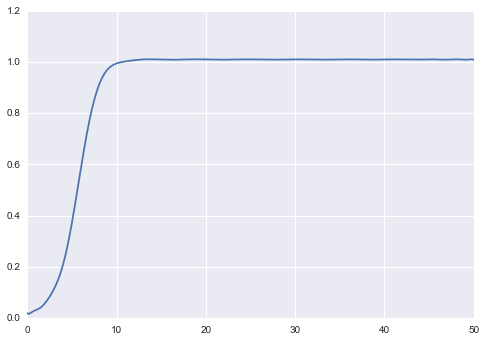

In [96]:
plt.plot(ts, initial_user_cost_poly(ts))
plt.show()

In [97]:
basic_model_solver.solve(kind="Chebyshev",
                         coefs_dict=initial_coefs,
                         domain=domain)


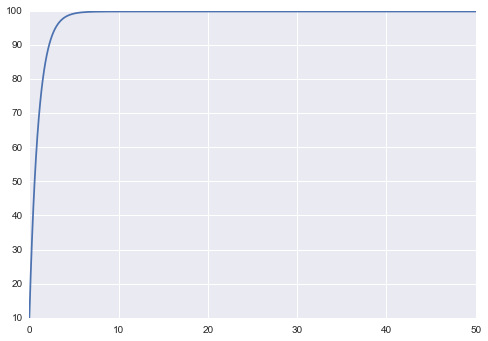

In [98]:
plt.plot(ts, basic_model_solver.functions['K'](ts))
plt.show()

In [99]:
basic_model_solver.functions['K']

Chebyshev([  9.26212320e+01,   1.41161829e+01,  -1.32780395e+01,
         1.19916966e+01,  -1.04000324e+01,   8.66368621e+00,
        -6.93455789e+00,   5.33509842e+00,  -3.94690277e+00,
         2.80908065e+00,  -1.92436470e+00,   1.26958889e+00,
        -8.07126475e-01,   4.94747476e-01,  -2.92589100e-01,
         1.67047684e-01,  -9.21318798e-02,   4.91188773e-02,
        -2.53302066e-02,   1.26433796e-02,  -6.11226954e-03,
         2.86374825e-03,  -1.30117242e-03,   5.73684590e-04,
        -2.45592696e-04,   1.02146353e-04,  -4.12998796e-05,
         1.62422536e-05,  -6.21646379e-06,   2.31689889e-06,
        -8.41054641e-07,   2.97710596e-07,  -1.02441608e-07,
         3.45174601e-08,  -1.08580289e-08,   3.49532599e-09], [  0.,  50.], [-1,  1])

In [100]:
initial_coefs.items()

[('q', array([  9.26212340e+01,   1.41161815e+01,  -1.32780355e+01,
           1.19916951e+01,  -1.04000282e+01,   8.66368469e+00,
          -6.93455345e+00,   5.33509681e+00,  -3.94689800e+00,
           2.80907890e+00,  -1.92435949e+00,   1.26958695e+00,
          -8.07120682e-01,   4.94745300e-01,  -2.92582537e-01,
           1.67045196e-01,  -9.21242979e-02,   4.91159811e-02,
          -2.53212421e-02,   1.26399316e-02,  -6.10133571e-03,
           2.85951705e-03,  -1.28716217e-03,   5.68233558e-04,
          -2.25725518e-04,   9.43777999e-05])),
 ('K', array([  9.26212320e+01,   1.41161829e+01,  -1.32780395e+01,
           1.19916966e+01,  -1.04000324e+01,   8.66368621e+00,
          -6.93455789e+00,   5.33509842e+00,  -3.94690277e+00,
           2.80908065e+00,  -1.92436470e+00,   1.26958889e+00,
          -8.07126475e-01,   4.94747476e-01,  -2.92589100e-01,
           1.67047684e-01,  -9.21318798e-02,   4.91188773e-02,
          -2.53302066e-02,   1.26433796e-02,  -6.11226954e-0

In [101]:
basic_model_solution = pycollocation.Solution(basic_model_solver)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x110296ed0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10e95f6d0>], dtype=object)

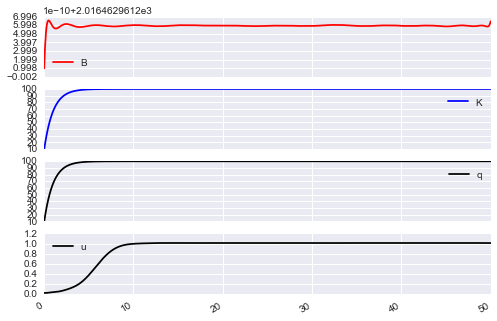

In [102]:
basic_model_solution.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
basic_model_solution.solution.plot(subplots=True, style=['r', 'b'])

In [103]:
basic_model_solution.solution

,B,K,q,u
0.000000,2016.462961,10.000000,10.000204,0.018300
0.050050,2016.462961,14.385088,14.385142,0.016480
0.100100,2016.462961,18.556105,18.556064,0.015600
0.150150,2016.462961,22.523500,22.523406,0.015428
0.200200,2016.462961,26.297214,26.297097,0.015773
0.250250,2016.462961,29.886702,29.886585,0.016482
0.300300,2016.462961,33.300957,33.300855,0.017432
0.350350,2016.462961,36.548535,36.548455,0.018528
0.400400,2016.462961,39.637572,39.637520,0.019697
0.450450,2016.462961,42.575808,42.575784,0.020884


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1102e8d50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x110638d90>], dtype=object)

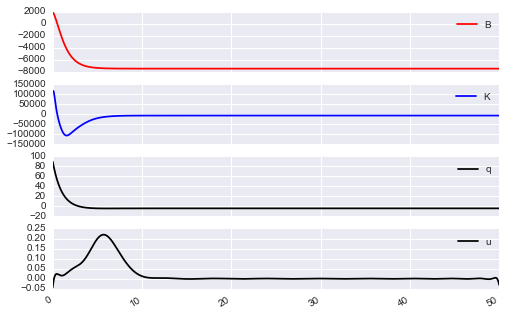

In [104]:
basic_model_solution.residuals.plot(subplots=True, style=['r', 'b'])


In [89]:
basic_model_solution.residuals

,B,K,q,u
0.000000,1921.145300,-5916.517850,89.340442,-0.044671
0.050050,1819.332710,-7066.475569,84.735460,-0.025579
0.100100,1688.498187,-10245.920509,80.355938,-0.010689
0.150150,1533.296256,-15123.396134,76.190711,0.000683
0.200200,1357.845940,-21072.756035,72.229191,0.009135
0.250250,1165.786227,-27484.653920,68.461328,0.015191
0.300300,960.326050,-33938.247563,64.877585,0.019307
0.350350,744.289304,-40213.576872,61.468907,0.021876
0.400400,520.155376,-46231.623347,58.226698,0.023239
0.450450,290.095636,-51990.122245,55.142794,0.023683


In [32]:
from quantecon import ivp

ImportError: No module named quantecon

In [949]:
def credit_cycles(t, X, a, m, alpha, R, K_bar):
    out = np.array([(1 / X[3]) * ((a + X[2]) * X[0] - R * X[1]) - X[0], 
                    (1 / R) * X[2] * X[0] - X[1],
                    (R - 1) * X[2] - R * X[3],
                    (alpha / R) * ((1 / m) * (K_bar - X[0]))**(alpha - 1) - X[3]])
    return out

def jacobian(t, X, a, m, alpha, R, K_bar):
    out = np.array([[((a + X[2]) / X[3]) - 1.0, -R / X[3], X[0] / X[3], -X[3]**(-2)],
                    [(1 / R) * X[2], -1.0, (1 / R) * X[0], 0.0],
                    [0.0, 0.0, R - 1, -R],
                    [-(1 / m) * (alpha - 1) * (alpha / R) * ((1 / m) * (K_bar - X[0]))**(alpha - 2), 0.0, 0.0, -1.0]])
    return out

def Kstar(a, m, alpha, R, K_bar):
    return K_bar - m * (alpha / (a * R))**(1 / (1 - alpha))

def Bstar(a, m, alpha, R, K_bar):
    return (a / (R - 1)) * Kstar(a, m, alpha, R, K_bar)


In [1068]:
initial_condition = np.array([Kstar(a, m, alpha, R, K_bar), Bstar(a, m, alpha, R, K_bar), (R / (R - 1)) * a, a])

In [1069]:
initial_condition

array([  9.99771401e+02,   1.04975997e+05,   1.06050000e+02,
         1.05000000e+00])

In [901]:
credit_cycles(0, initial_condition)

array([ -8.64019967e-12,   0.00000000e+00,   0.00000000e+00,
        -9.88098492e-14])

In [868]:
jacobian(0, initial_condition)

array([[  1.01000000e+02,  -9.61904762e-01,   9.52163239e+02,
         -9.07029478e-01],
       [  1.05000000e+02,  -1.00000000e+00,   9.89872674e+02,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e-02,
         -1.01000000e+00],
       [  2.15879931e+00,   0.00000000e+00,   0.00000000e+00,
         -1.00000000e+00]])

In [869]:
from scipy import linalg

In [902]:
from IPython.html.widgets import fixed, interact, FloatSliderWidget

In [1074]:
def eigenvalues(a=1.0, m=1.0, alpha=0.33, R=1.05, K_bar=10.0):
    steady_state = np.array([Kstar(a, m, alpha, R, K_bar),
                             Bstar(a, m, alpha, R, K_bar),
                             (R / (R - 1)) * a,
                             a])
    vals, vecs = linalg.eig(jacobian(0, steady_state, a, m, alpha, R, K_bar))
    print vals

In [1103]:
interact(eigenvalues, a=(0.0, 1e3, 1e0), m=(0.0, 1e2, 1e-1), R=(0.0, 1e2, 1e-2), K_bar=(0.0, 1e3, 1e1))

[  9.88748655e+01+0.j   1.01851410e+01+0.j  -1.00500164e+01+0.j
   9.89097957e-06+0.j]


In [1120]:
params = 2.0, 0.5, 0.33, 1.01, 500.0
problem = ivp.IVP(credit_cycles, jacobian)
problem.f_params = params
problem.jac_params = params

In [1121]:
initial_condition = np.array([0.99999 * Kstar(*params), Bstar(*params), (params[3] / (params[3] - 1)) * params[0], params[0]])
traj = problem.solve(0, initial_condition, h=1e-2, T=200, integrator='lsoda')

In [1122]:
traj

array([[  0.00000000e+00,   4.99961536e+02,   9.99933071e+04,
          2.02000000e+02,   2.00000000e+00],
       [  1.00000000e-02,   4.99956927e+02,   9.99932923e+04,
          2.02000012e+02,   1.99750927e+00],
       [  2.00000000e-02,   4.99957063e+02,   9.99932722e+04,
          2.02000053e+02,   1.99427774e+00],
       ..., 
       [  1.99990000e+02,              nan,              nan,
                     nan,              nan],
       [  2.00000000e+02,              nan,              nan,
                     nan,              nan],
       [  2.00010000e+02,              nan,              nan,
                     nan,              nan]])

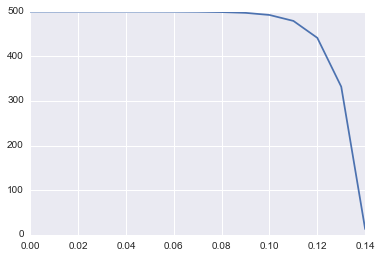

In [1128]:
plt.plot(traj[:15,0], traj[:15,1])
plt.show()

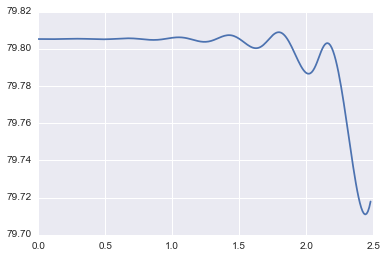

In [1112]:
plt.plot(traj[:,0], traj[:,2])
plt.show()

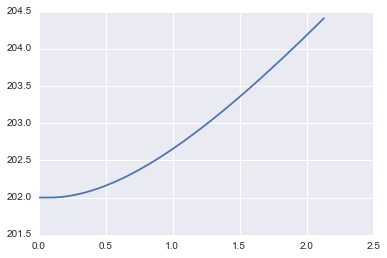

In [1119]:
plt.plot(traj[:,0], traj[:,3])
plt.show()

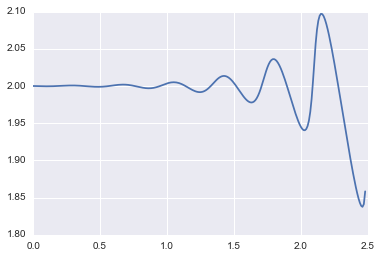

In [1114]:
plt.plot(traj[:,0], traj[:,4])
plt.show()

In [1088]:
problem.successful()

False

In [606]:
from scipy import optimize

In [624]:
Bstar(1.5, 10, 0.95, 1.01, 100)

14999.867471064967

In [674]:
optimize.root(lambda X: credit_cycles(0, X, *params),
              x0=initial_condition,
              method='hybr')

  status: 5
 success: False
     qtf: array([ 176.20586429,  164.07642329,    1.04059789,   -0.33842923])
    nfev: 19
       r: array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])
     fun: array([-165.04418296, -175.2998186 ,   -1.0605    ,   -0.20803305])
       x: array([   8.34761041,  175.2998186 ,    0.        ,    1.05      ])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    fjac: array([[ -9.97838553e-01,  -6.57057743e-02,   6.43314093e-12,
         -9.86957767e-04],
       [  6.57043249e-02,  -9.97838104e-01,   1.46733257e-10,
          1.43553260e-03],
       [  5.76367792e-04,  -7.30420116e-04,  -8.45423968e-01,
         -5.34094981e-01],
       [  9.12336608e-04,  -1.15618684e-03,   5.34095791e-01,
         -8.45422685e-01]])